In [1]:
%load_ext autoreload

In [367]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

In [39]:
dt_orig = dt

# Delayed MI

In [9]:
delayed_mi = pd.read_pickle('__data__/delayed_mi_wake.pkl')

In [10]:
def pick_tau(signal, method='knee'):
    if method == 'local_min':
        local_min_inds = scipy.signal.argrelextrema(signal, np.less)[0]
        if len(local_min_inds) == 0:
            tau = signal.argmin()
        else:
            tau = local_min_inds[0]
    else: # method == 'knee'
        kneedle = KneeLocator(np.arange(len(signal)), signal, S=1, curve='convex', direction='decreasing')
    
    return kneedle.knee

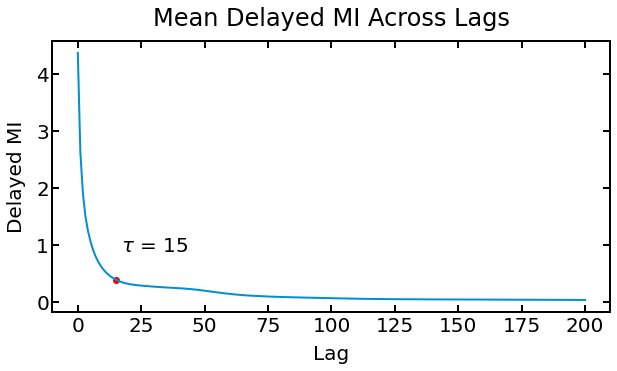

In [11]:
# dim = 23
# tau = pick_tau(delayed_mi[:, dim])
# plt.plot(delayed_mi[:, dim])
# plt.scatter(tau, delayed_mi[tau, dim], c='red')
# plt.xlabel('Lag')
# plt.ylabel('Delayed MI')
# plt.title(f'Delayed MI Dimension {dim}')
# plt.text(tau + 2, delayed_mi[tau, dim] + 0.5, fr"$\tau$ = {tau}")
# plt.show()

mean_delayed_mi = delayed_mi.mean(axis=1)
tau = pick_tau(mean_delayed_mi)

plt.plot(mean_delayed_mi)
plt.scatter(tau, mean_delayed_mi[tau], c='red')
plt.xlabel('Lag')
plt.ylabel('Delayed MI')
plt.title('Mean Delayed MI Across Lags')
plt.text(tau + 2, mean_delayed_mi[tau] + 0.5, fr"$\tau$ = {tau}")
plt.show()

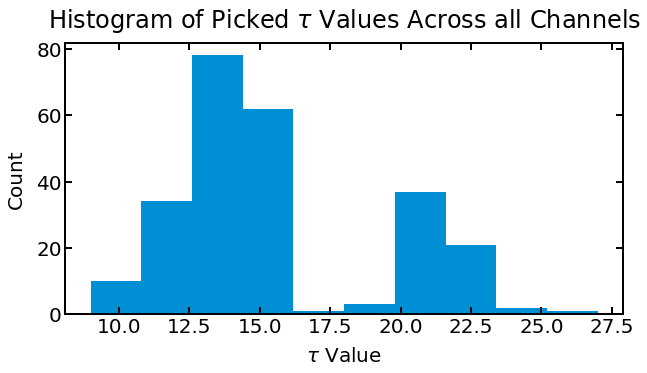

In [12]:
taus = []
for j in range(delayed_mi.shape[1]):
    taus.append(pick_tau(delayed_mi[:, j]))

plt.hist(taus)
plt.xlabel(r'$\tau$ Value')
plt.ylabel('Count')
plt.title(r'Histogram of Picked $\tau$ Values Across all Channels')
plt.show()

In [13]:
lfp_subsampled = lfp[np.arange(0, lfp.shape[0], tau)]

In [40]:
dt = dt_orig*tau

# Test VAR(p)

In [266]:
window = 10000
p = 30
window_start = 5000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]
d = len(unit_indices)

In [267]:
train_signal = lfp_subsampled[start:start + window, unit_indices]

In [268]:
H = embed_signal(train_signal, p, 1, direction='reverse')

In [269]:
H.shape

(9971, 1920)

In [270]:
coefs = np.linalg.lstsq(H[:-1], H[1:, :d], rcond=1e-14)[0].T

In [271]:
train_preds_one_step = (coefs @ H[:-1].T).T
train_persistence_baseline = H[:-1, :d]

In [272]:
train_one_step_error = np.linalg.norm(train_preds_one_step - train_signal[p:])/np.linalg.norm(train_signal[p:])
train_persistence_baseline_error = np.linalg.norm(train_persistence_baseline - train_signal[p:])/np.linalg.norm(train_signal[p:])

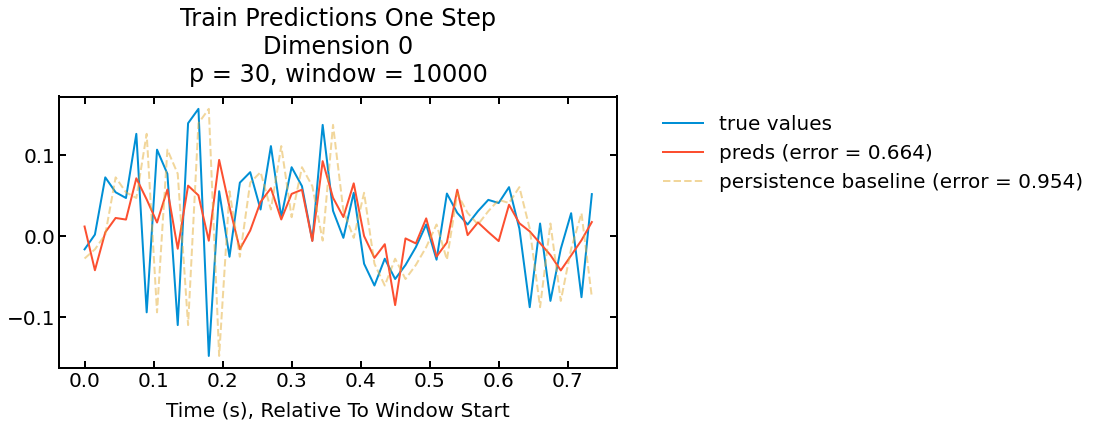

In [279]:
start = 0
end = 50
ind = 0
time_vals = np.arange(start, end)*dt
plt.plot(time_vals, train_signal[p + start:p + end, 0], label='true values')
plt.plot(time_vals, train_preds_one_step[start:end, 0], label=f'preds (error = {train_one_step_error:.3f})')
plt.plot(time_vals, train_persistence_baseline[start:end, 0], label=f'persistence baseline (error = {train_persistence_baseline_error:.3f})', linestyle='--', alpha=0.5)
plt.title(f'Train Predictions One Step\nDimension {ind}\np = {p}, window = {window}')
plt.xlabel('Time (s), Relative To Window Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [274]:
T_pred = 500
test_signal = lfp_subsampled[window_start + window - p:window_start + window + T_pred, unit_indices]
H_test = embed_signal(test_signal, p, 1, direction='reverse')

In [275]:
test_preds_one_step = (coefs @ H_test[:-1].T).T
test_persistence_baseline = H_test[:-1, :d]

In [276]:
test_one_step_error = np.linalg.norm(test_preds_one_step - test_signal[p:])/np.linalg.norm(test_signal[p:])
test_persistence_baseline_error = np.linalg.norm(test_persistence_baseline - test_signal[p:])/np.linalg.norm(test_signal[p:])

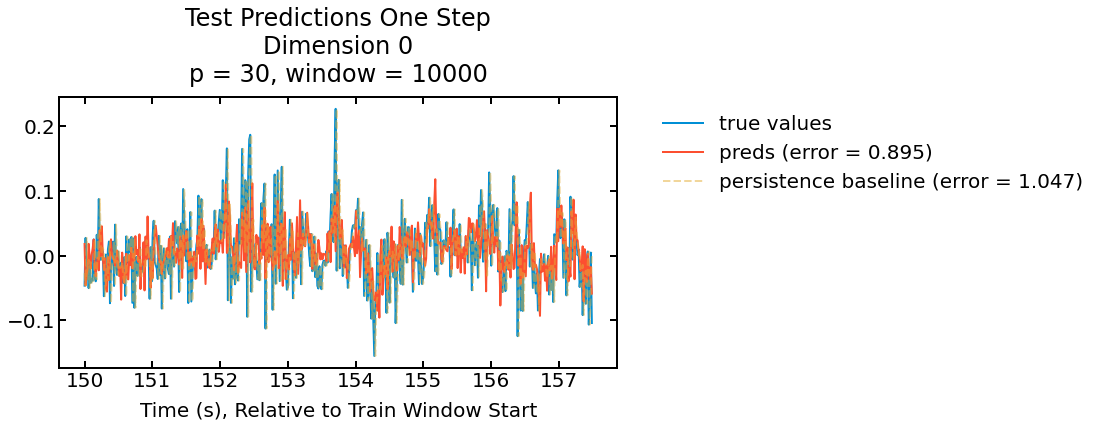

In [277]:
start = 0
end = 500
ind = 0
time_vals = np.arange(start + window, end + window)*dt
plt.plot(time_vals, test_signal[p + start:p + end, 0], label='true values')
plt.plot(time_vals, test_preds_one_step[start:end, 0], label=f'preds (error = {test_one_step_error:.3f})')
plt.plot(time_vals, test_persistence_baseline[start:end, 0], label=f'persistence baseline (error = {test_persistence_baseline_error:.3f})', linestyle='--', alpha=0.5)
plt.title(f'Test Predictions One Step\nDimension {ind}\np = {p}, window = {window}')
plt.xlabel('Time (s), Relative to Train Window Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [278]:
def compute_A_mat(coefs, expanded=False):
    if expanded:
        d = coefs.shape[0]
        p = int(coefs.shape[1]/d)
    else:
        p, d = coefs.shape[0], coefs.shape[1]
    
    A = np.zeros((d*p, d*p))
    for i in range(p):
        if expanded:
            mat = coefs[:d, :][:, i*d:(i + 1)*d]
        else:
            mat = coefs[p]
        
        A[:d, :][:, i*d:(i + 1)*d] = mat
        if i < p - 1:
            A[(i + 1)*d:(i + 2)*d, :][:, i*d:(i + 1)*d] = np.eye(d)
    
    return A

In [264]:
A = compute_A_mat(coefs, expanded=True)

In [280]:
# cis = np.sort(np.abs(np.linalg.eigvals(A)))[::-1]

In [ ]:
plt.plot(cis)
plt.xlabel('Criticality Ind #')
plt.show()

### Chained Prediction

In [145]:
H_train_recon = np.zeros(H.shape)
H_train_recon[0] = H[0]
for t in range(1, H.shape[0]):
    H_train_recon[t] = A @ H_train_recon[t - 1]
train_preds_chained = H_train_recon[1:, :d]

In [146]:
H_test_recon = np.zeros(H_test.shape)
H_test_recon[0] = H_test[0]
for t in range(1, H_test.shape[0]):
    H_test_recon[t] = A @ H_test_recon[t - 1]
test_preds_chained = H_test_recon[1:, :d]

In [147]:
train_chained_error = np.linalg.norm(train_preds_chained - train_signal[p:])/np.linalg.norm(train_signal[p:])
test_chained_error = np.linalg.norm(test_preds_chained - test_signal[p:])/np.linalg.norm(test_signal[p:])

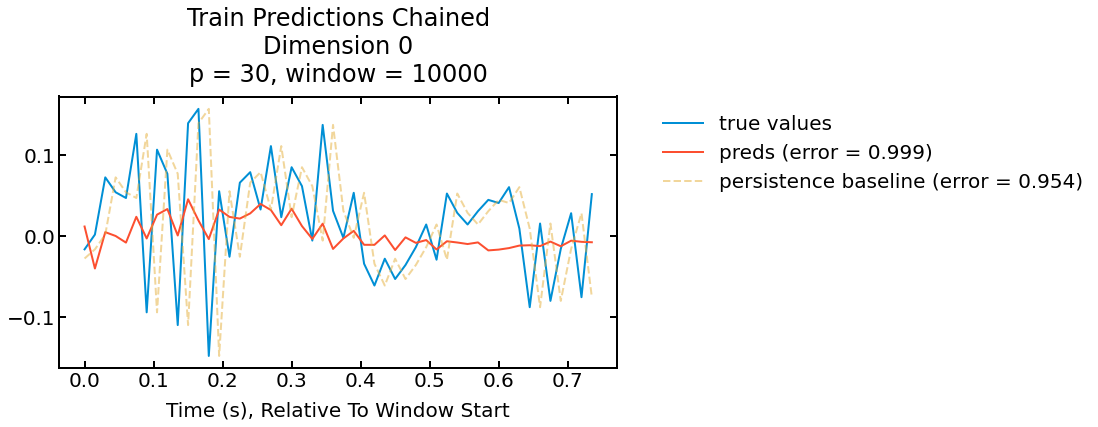

In [148]:
start = 0
end = 50
ind = 0
time_vals = np.arange(start, end)*dt
plt.plot(time_vals, train_signal[p + start:p + end, 0], label='true values')
plt.plot(time_vals, train_preds_chained[start:end, 0], label=f'preds (error = {train_chained_error:.3f})')
plt.plot(time_vals, train_persistence_baseline[start:end, 0], label=f'persistence baseline (error = {train_persistence_baseline_error:.3f})', linestyle='--', alpha=0.5)
plt.title(f'Train Predictions Chained\nDimension {ind}\np = {p}, window = {window}')
plt.xlabel('Time (s), Relative To Window Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

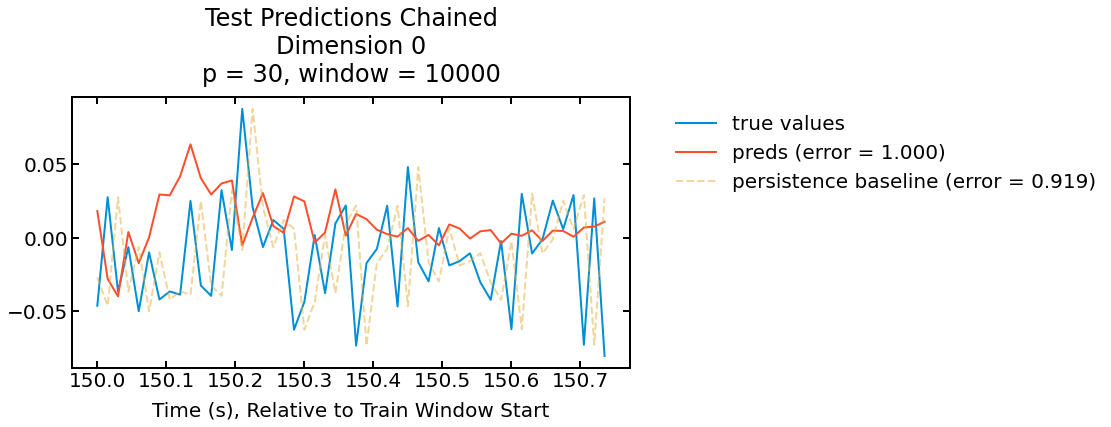

In [149]:
start = 0
end = 50
ind = 0
time_vals = np.arange(start + window, end + window)*dt
plt.plot(time_vals, test_signal[p + start:p + end, 0], label='true values')
plt.plot(time_vals, test_preds_chained[start:end, 0], label=f'preds (error = {test_chained_error:.3f})')
plt.plot(time_vals, test_persistence_baseline[start:end, 0], label=f'persistence baseline (error = {test_persistence_baseline_error:.3f})', linestyle='--', alpha=0.5)
plt.title(f'Test Predictions Chained\nDimension {ind}\np = {p}, window = {window}')
plt.xlabel('Time (s), Relative to Train Window Start')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Testing on Surrogates

In [187]:
surrogate_window = 300 # s
surrogate_window = int(surrogate_window/dt)

In [190]:
lfp_surrogate = np.zeros((surrogate_window, d))
for i in tqdm(range(d)):
    lfp_surrogate[:, i] = surrogates(lfp_subsampled[:surrogate_window, i], ns=1, verbose=False)

  0%|          | 0/64 [00:00<?, ?it/s]

In [191]:
train_signal_surrogate = lfp_surrogate[window_start:window_start + window]
H_surrogate = embed_signal(train_signal_surrogate, p, 1, direction='reverse')

In [192]:
coefs_surrogate = np.linalg.lstsq(H_surrogate[:-1], H_surrogate[1:, :d], rcond=1e-14)[0].T

In [199]:
train_preds_one_step_surrogate = (coefs_surrogate @ H_surrogate[:-1].T).T
train_preds_one_step_O2S = (coefs @ H_surrogate[:-1].T).T
train_preds_one_step_S2O = (coefs_surrogate @ H[:-1].T).T
train_persistence_baseline_surrogate = H_surrogate[:-1, :d]

In [202]:
train_one_step_error_surrogate = np.linalg.norm(train_preds_one_step_surrogate - train_signal_surrogate[p:])/np.linalg.norm(train_signal_surrogate[p:])
train_one_step_error_O2S = np.linalg.norm(train_preds_one_step_O2S - train_signal_surrogate[p:])/np.linalg.norm(train_signal_surrogate[p:])
train_one_step_error_S2O = np.linalg.norm(train_preds_one_step_S2O - train_signal[p:])/np.linalg.norm(train_signal[p:])
train_persistence_baseline_error_surrogate = np.linalg.norm(train_persistence_baseline_surrogate - train_signal_surrogate[p:])/np.linalg.norm(train_signal_surrogate[p:])

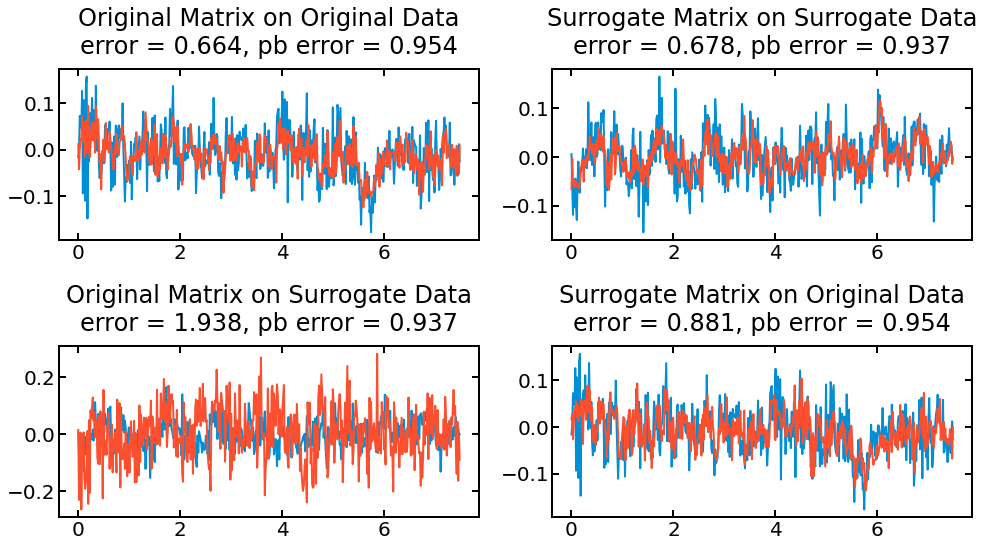

In [208]:
start = 0
end = 500
ind = 0
time_vals = np.arange(start, end)*dt
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
ax = axs[0][0]
ax.plot(time_vals[start:end], train_signal[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], train_preds_one_step[start:end, ind], label='preds')
ax.set_title(f'Original Matrix on Original Data\nerror = {train_one_step_error:.3f}, pb error = {train_persistence_baseline_error:.3f}')

ax = axs[0][1]
ax.plot(time_vals[start:end], train_signal_surrogate[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], train_preds_one_step_surrogate[start:end, ind], label='preds')
ax.set_title(f'Surrogate Matrix on Surrogate Data\nerror = {train_one_step_error_surrogate:.3f}, pb error = {train_persistence_baseline_error_surrogate:.3f}')

ax = axs[1][0]
ax.plot(time_vals[start:end], train_signal_surrogate[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], train_preds_one_step_O2S[start:end, ind], label='preds')
ax.set_title(f'Original Matrix on Surrogate Data\nerror = {train_one_step_error_O2S:.3f}, pb error = {train_persistence_baseline_error_surrogate:.3f}')

ax = axs[1][1]
ax.plot(time_vals[start:end], train_signal[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], train_preds_one_step_S2O[start:end, ind], label='preds')
ax.set_title(f'Surrogate Matrix on Original Data\nerror = {train_one_step_error_S2O:.3f}, pb error = {train_persistence_baseline_error:.3f}')


plt.tight_layout()

plt.show()

In [243]:
test_signal_surrogate = lfp_surrogate[window_start + window - p:window_start + window + T_pred, unit_indices]
H_test_surrogate = embed_signal(test_signal_surrogate, p, 1, direction='reverse')

In [245]:
test_preds_one_step_surrogate = (coefs_surrogate @ H_test_surrogate[:-1].T).T
test_preds_one_step_O2S = (coefs @ H_test_surrogate[:-1].T).T
test_preds_one_step_S2O = (coefs_surrogate @ H_test[:-1].T).T
test_persistence_baseline_surrogate = H_test_surrogate[:-1, :d]

test_one_step_error_surrogate = np.linalg.norm(test_preds_one_step_surrogate - test_signal_surrogate[p:])/np.linalg.norm(test_signal_surrogate[p:])
test_one_step_error_O2S = np.linalg.norm(test_preds_one_step_O2S - test_signal_surrogate[p:])/np.linalg.norm(test_signal_surrogate[p:])
test_one_step_error_S2O = np.linalg.norm(test_preds_one_step_S2O - test_signal[p:])/np.linalg.norm(test_signal[p:])
test_persistence_baseline_error_surrogate = np.linalg.norm(test_persistence_baseline_surrogate - test_signal_surrogate[p:])/np.linalg.norm(test_signal_surrogate[p:])

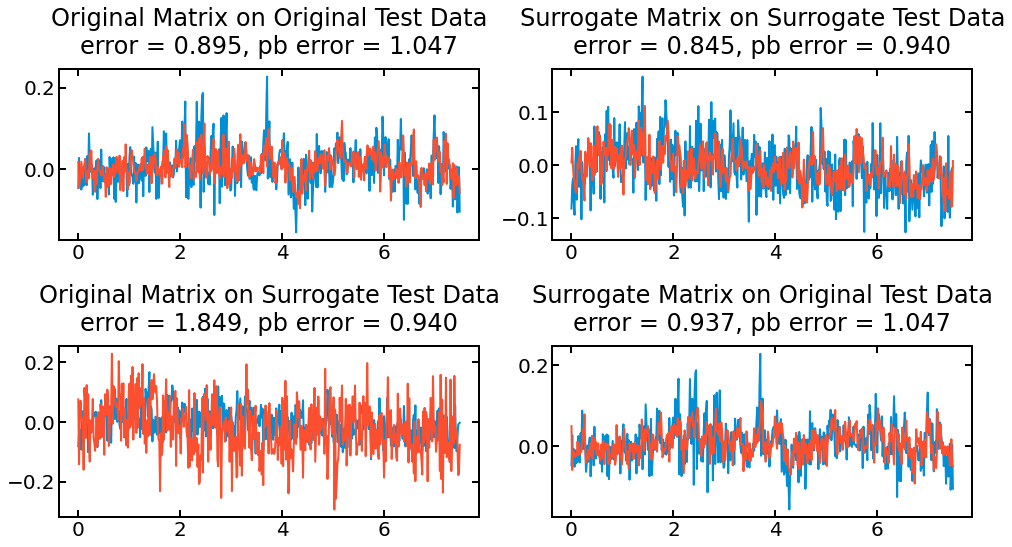

In [246]:
start = 0
end = 500
ind = 0
time_vals = np.arange(start, end)*dt
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
ax = axs[0][0]
ax.plot(time_vals[start:end], test_signal[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], test_preds_one_step[start:end, ind], label='preds')
ax.set_title(f'Original Matrix on Original Test Data\nerror = {test_one_step_error:.3f}, pb error = {test_persistence_baseline_error:.3f}')

ax = axs[0][1]
ax.plot(time_vals[start:end], test_signal_surrogate[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], test_preds_one_step_surrogate[start:end, ind], label='preds')
ax.set_title(f'Surrogate Matrix on Surrogate Test Data\nerror = {test_one_step_error_surrogate:.3f}, pb error = {test_persistence_baseline_error_surrogate:.3f}')

ax = axs[1][0]
ax.plot(time_vals[start:end], test_signal_surrogate[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], test_preds_one_step_O2S[start:end, ind], label='preds')
ax.set_title(f'Original Matrix on Surrogate Test Data\nerror = {test_one_step_error_O2S:.3f}, pb error = {test_persistence_baseline_error_surrogate:.3f}')

ax = axs[1][1]
ax.plot(time_vals[start:end], test_signal[p + start:p + end, ind], label='true values')
ax.plot(time_vals[start:end], test_preds_one_step_S2O[start:end, ind], label='preds')
ax.set_title(f'Surrogate Matrix on Original Test Data\nerror = {test_one_step_error_S2O:.3f}, pb error = {test_persistence_baseline_error:.3f}')


plt.tight_layout()

plt.show()

In [247]:
A_surrogate = compute_A_mat(coefs_surrogate, expanded=True)

In [248]:
cis_surrogate = np.sort(np.abs(np.linalg.eigvals(A_surrogate)))[::-1]

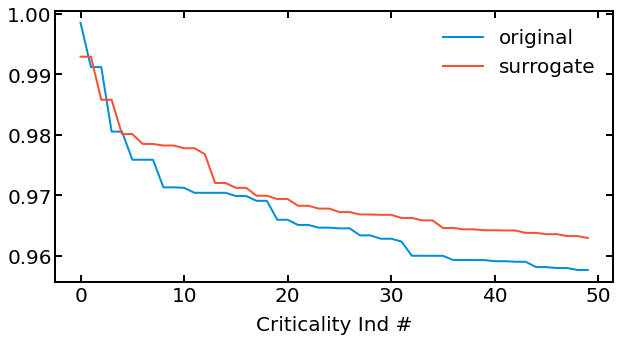

In [249]:
start = 0
end = 50
plt.plot(cis[start:end], label='original')
plt.plot(cis_surrogate[start:end], label='surrogate')
plt.xlabel('Criticality Ind #')
plt.legend()
plt.show()

## Hankel Time Delay Space

In [281]:
window = 10000
p = 30
window_start = 5000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]
d = len(unit_indices)

In [282]:
train_signal = lfp_subsampled[start:start + window, unit_indices]

H = embed_signal(train_signal, p, 1, direction='reverse')

In [283]:
U, S, Vh = np.linalg.svd(H.T)

In [290]:
S_mat = np.zeros(U.shape)
S_mat[np.arange(len(S)), np.arange(len(S))] = S
V = Vh.T

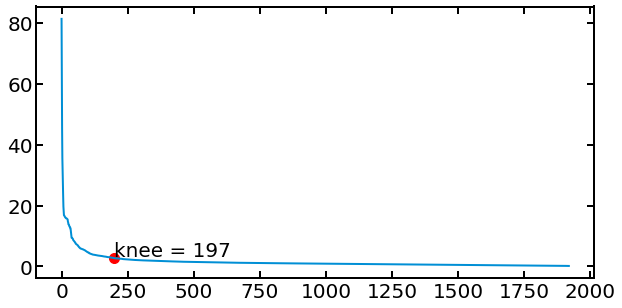

In [287]:
knee = KneeLocator(np.arange(len(S)), S, S=40, curve='convex', direction='decreasing').knee
plt.plot(S)
plt.scatter(knee, S[knee], c='red', s=100)
plt.text(knee, S[knee]*1.2, f"knee = {knee}")
plt.show()

In [288]:
r = knee*2

In [296]:
H_recon_r = (U @ S_mat[:, :r] @ V[:, :r].T).T
H_recon_r_error = np.linalg.norm(H_recon_r - H)/np.linalg.norm(H)

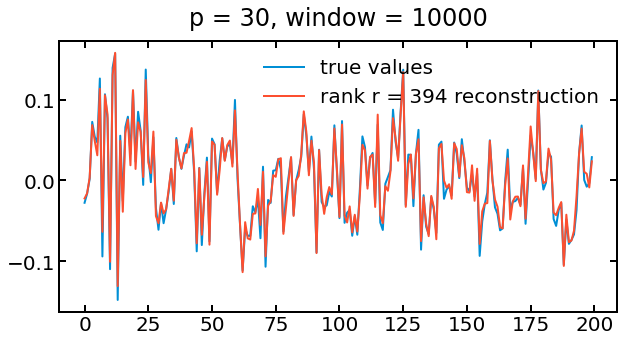

In [302]:
plt.plot(H[:200, 0], label='true values')
plt.plot(H_recon_r[:200, 0], label=f'rank r = {r} reconstruction')
plt.legend()
plt.title(f"p = {p}, window = {window}")
plt.show()

In [303]:
DMD_mat = np.linalg.lstsq(V[:-1, :r], V[1:, :r], rcond=1e-14)[0].T

In [319]:
V_recon = (DMD_mat @ V[:-1, :r].T).T
V_recon = np.vstack([V[[0], :r], V_recon])

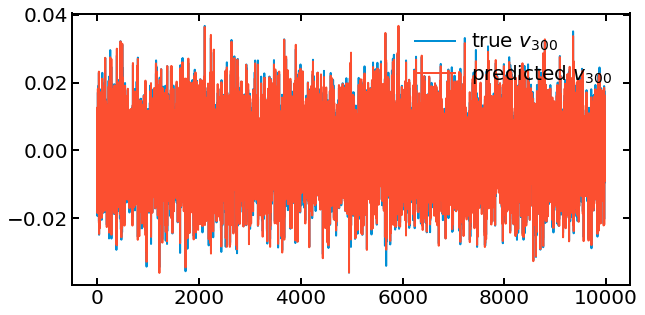

In [331]:
ind = 300
plt.plot(V[:, ind], label='true $v_{%d}$' % ind)
plt.plot(V_recon[:, ind], label='predicted $v_{%d}$' % ind)
plt.legend()
plt.show()

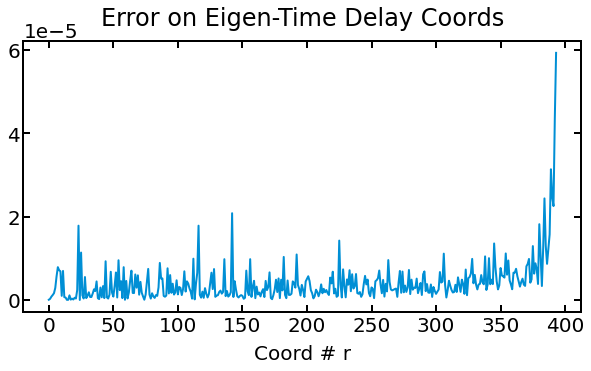

In [337]:
plt.plot(((V_recon - V[:, :r])**2).mean(axis=0))
plt.title('Error on Eigen-Time Delay Coords')
plt.xlabel('Coord # r')
plt.show()

In [339]:
H_recon = (U @ S_mat[:, :r] @ V_recon.T).T

In [360]:
V_recon_chained = np.zeros(V[:, :r].shape)
V_recon_chained[0] = V[0, :r]
for t in range(1, V.shape[0]):
    V_recon_chained[t] = DMD_mat @ V_recon_chained[t - 1]
H_recon_chained = (U @ S_mat[:, :r] @ V_recon_chained.T).T

In [413]:
np.linalg.norm(H_recon[1:] - H[1:])/np.linalg.norm(H[1:]), r2_score(H[1:], H_recon[1:])

(0.23922449319055478, 0.9430516044163705)

In [414]:
np.linalg.norm(H_recon_chained[1:] - H[1:])/np.linalg.norm(H[1:]), r2_score(H[1:], H_recon_chained[1:])

(0.9985683357398407, 0.0009762757332152529)

In [415]:
H_recon_r_error, r2_score(H[1:], H_recon_r[1:])

(0.20106898045266466, 0.9596876739196571)

In [376]:
np.linalg.norm(H.mean(axis=0) - H[1:])/np.linalg.norm(H[1:])

0.9990825439502048

In [416]:
np.linalg.norm(H[:-1] - H[1:])/np.linalg.norm(H[1:]), r2_score(H[1:], H[:-1])

(0.9537740317343784, 0.11176538798952021)

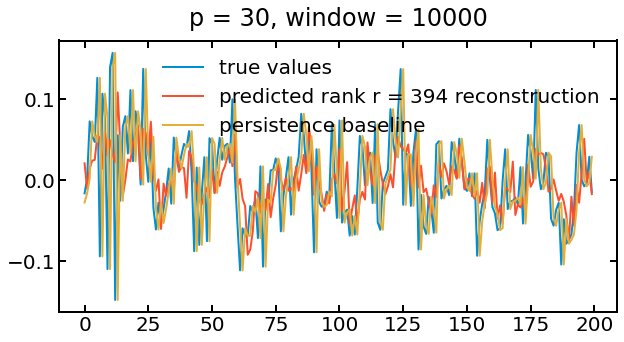

In [389]:
ind = 0
start = 0
end = 200
plt.plot(H[1 + start:1 + end, ind], label='true values')
plt.plot(H_recon[1 + start:1 + end, ind], label=f'predicted rank r = {r} reconstruction')
plt.plot(H[start:end, ind], label='persistence baseline')
plt.legend()
plt.title(f"p = {p}, window = {window}")
plt.show()

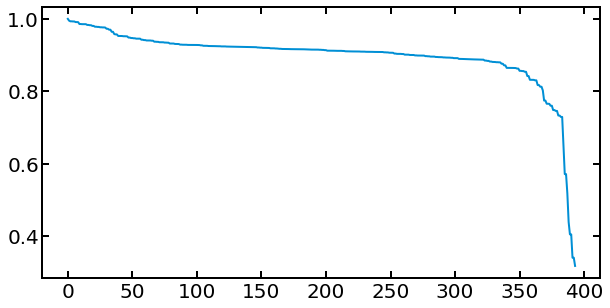

In [344]:
plt.plot(np.sort(np.abs(np.linalg.eigvals(DMD_mat)))[::-1])

In [ ]:
plt.plot(H_recon)

In [412]:
np.linalg.norm(H_recon[1:, :d] - H[1:, :d])/np.linalg.norm(H[1:, :d]), r2_score(H[1:, :d], H_recon[1:, :d])

(0.7299626630295251, 0.4716994272961561)

In [417]:
np.linalg.norm(H_recon_chained[1:, :d] - H[1:, :d])/np.linalg.norm(H[1:, :d]), r2_score(H[1:, :d], H_recon_chained[1:, :d])

(0.9989847360408417, 0.00012386836806719224)

In [418]:
np.linalg.norm(H_recon_r[1:, :d] - H[1:, :d])/np.linalg.norm(H[1:, :d]), r2_score(H[1:, :d], H_recon_r[1:, :d])

(0.20367431329806732, 0.9585274556139148)

In [419]:
np.linalg.norm(H[:-1, :d] - H[1:, :d])/np.linalg.norm(H[1:, :d]), r2_score(H[1:, :d], H[:-1, :d])

(0.9537779594564452, 0.11187846659280765)

In [376]:
np.linalg.norm(H.mean(axis=0) - H[1:])/np.linalg.norm(H[1:])

0.9990825439502048

In [400]:
H_mean = np.repeat(H.mean(axis=0)[np.newaxis, :], H.shape[0], axis=0)

In [405]:
((H[1:, :d] - H_recon[1:, :d])**2).sum(a), ((H[1:, :d] - H[1:, :d].mean(axis=0))**2).sum()

(509.6329013020364, 954.6797034476475)

In [411]:
(1 - ((H[1:, :d] - H_recon[1:, :d])**2).sum(axis=0)/((H[1:, :d] - H[1:, :d].mean(axis=0))**2).sum(axis=0)).mean()

0.4716994272961561